In [1]:
# Robust portfolio comparison
# Based on Stanford ee364b lecture notes and convex optimization book
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
np.random.seed(0)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [2]:
np.random.seed(1)
n = 200
mu = 1.05 + 0.3 * np.linspace(1, 1 / n, n)
u_max = 0.05 + 0.6 * np.linspace(1, 1 / n, n)  # Uncertainty sets
u_max[-1] = 0  # Cash no variability
epsilon = 1e-2  # Risk parameter (probability of failure)
beta = 1e-09 # confidence
alpha = 1.1  # Unwanted return level

In [3]:
# Nominal and conservative allocations
x_nom = np.zeros(n); x_nom[0] = 1 # Nominal solution (best average return)
x_con = np.zeros(n); x_con[n-1] = 1 # Conservative solution (only cash)

In [4]:
# Robust allocation
x = cp.Variable(n)
objective = mu @ x
constraints = [mu @ x - np.sqrt(.5 * np.log(1/epsilon)) * cp.norm(np.diag(2 * u_max) @ x, 2) >= alpha,
               cp.sum(x) == 1, x >= 0]
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()
x_rob = x.value
time_rob = problem.solver_stats.solve_time

In [5]:
N_scenarios = int(np.ceil(2 / epsilon * (np.log(1/beta) + n - 1)))
N_scenarios

43945

In [6]:
# Scenario-based allocation
R = mu + u_max * (1 - 2 * np.random.rand(N_scenarios, n))   # scenarios

x = cp.Variable(n)
objective = mu @ x
constraints = [R @ x >= alpha,
               cp.sum(x) == 1, x >= 0]
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()  # It will take about a minute
x_sce = x.value
time_sce = problem.solver_stats.solve_time

In [7]:
# Simulate returns
num_samples = 2 * 10**5
returns_nom = np.zeros(num_samples)
returns_con = np.zeros(num_samples)
returns_rob = np.zeros(num_samples)
returns_sce = np.zeros(num_samples)
prob_loss_rob = 0
prob_loss_sce = 0

for sample in range(num_samples):
    r = mu + u_max * (1 - 2 * np.random.rand(n))
    returns_nom[sample] = r @ x_nom
    returns_con[sample] = r @ x_con
    returns_rob[sample] = r @ x_rob
    returns_sce[sample] = r @ x_sce
    prob_loss_rob += (r @ x_rob <= alpha)/num_samples
    prob_loss_sce += (r @ x_sce <= alpha)/num_samples

# Average returns
print("Robust:\n   Avg returns=%.5f" % np.mean(returns_rob))
print("   Empirical probability of unwanted loss: %.5f, epsilon=%.5f" % (prob_loss_rob, epsilon))
print("   Solve time: %.4f sec" % time_rob)

print("Scenario:\n   Avg returns=%.5f" % np.mean(returns_sce))
print("   Empirical probability of unwanted loss scenario: %.5f, epsilon=%.5f" % (prob_loss_sce, epsilon))
print("   Solve time: %.4f sec" % time_sce)

Robust:
   Avg returns=1.30046
   Empirical probability of unwanted loss: 0.00000, epsilon=0.01000
   Solve time: 0.0016 sec
Scenario:
   Avg returns=1.33359
   Empirical probability of unwanted loss scenario: 0.00073, epsilon=0.01000
   Solve time: 41.8098 sec


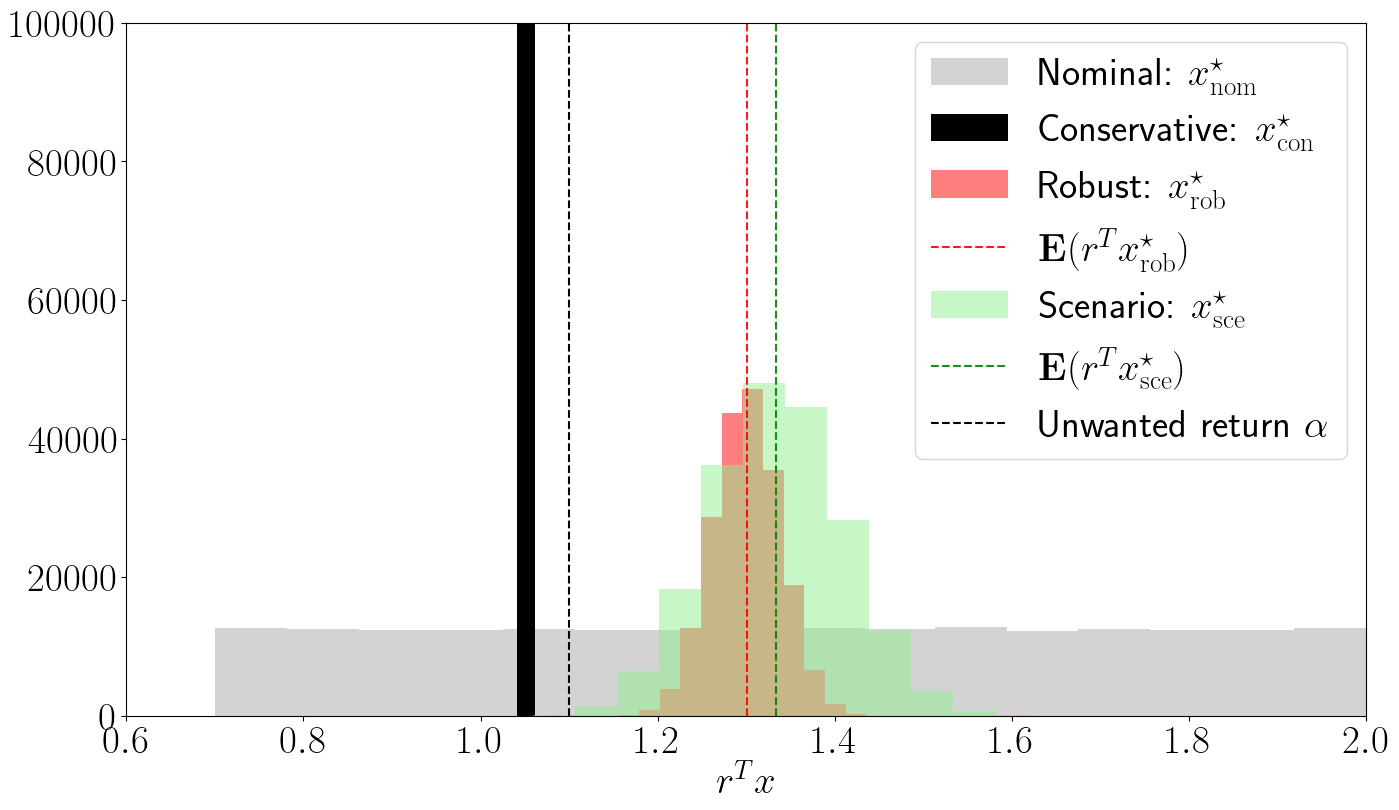

In [8]:
# Plot results
fig, ax = plt.subplots(figsize=(16, 9))
plt.hist(returns_nom, bins=16, color='lightgray', label=r"Nominal: $x^\star_{\rm nom}$")
plt.hist(returns_con, bins=[mu[-1] - 1e-2, mu[-1] + 1e-2], color='black', label=r"Conservative: $x^\star_{\rm con}$")
plt.hist(returns_rob, bins=14, color='#FF7F7F', label=r"Robust: $x^\star_{\rm rob}$")
plt.axvline(x=np.mean(returns_rob), color='red', linestyle='--', label=r'${\bf E}(r^Tx^\star_{\rm rob})$', alpha=0.9)
plt.hist(returns_sce, bins=14, color='#90EE90', label=r"Scenario: $x^\star_{\rm sce}$", alpha=0.5)
plt.axvline(x=np.mean(returns_sce), color='green', linestyle='--', label=r'${\bf E}(r^Tx^\star_{\rm sce})$', alpha=0.9)
plt.axis([0.6, 2, 0, num_samples / 2])
plt.axvline(x=alpha, color='black', linestyle='--', label=r'Unwanted return $\alpha$')
plt.legend()
plt.xlabel(r"$r^Tx$")
plt.savefig("portfolio.pdf", bbox_inches="tight")

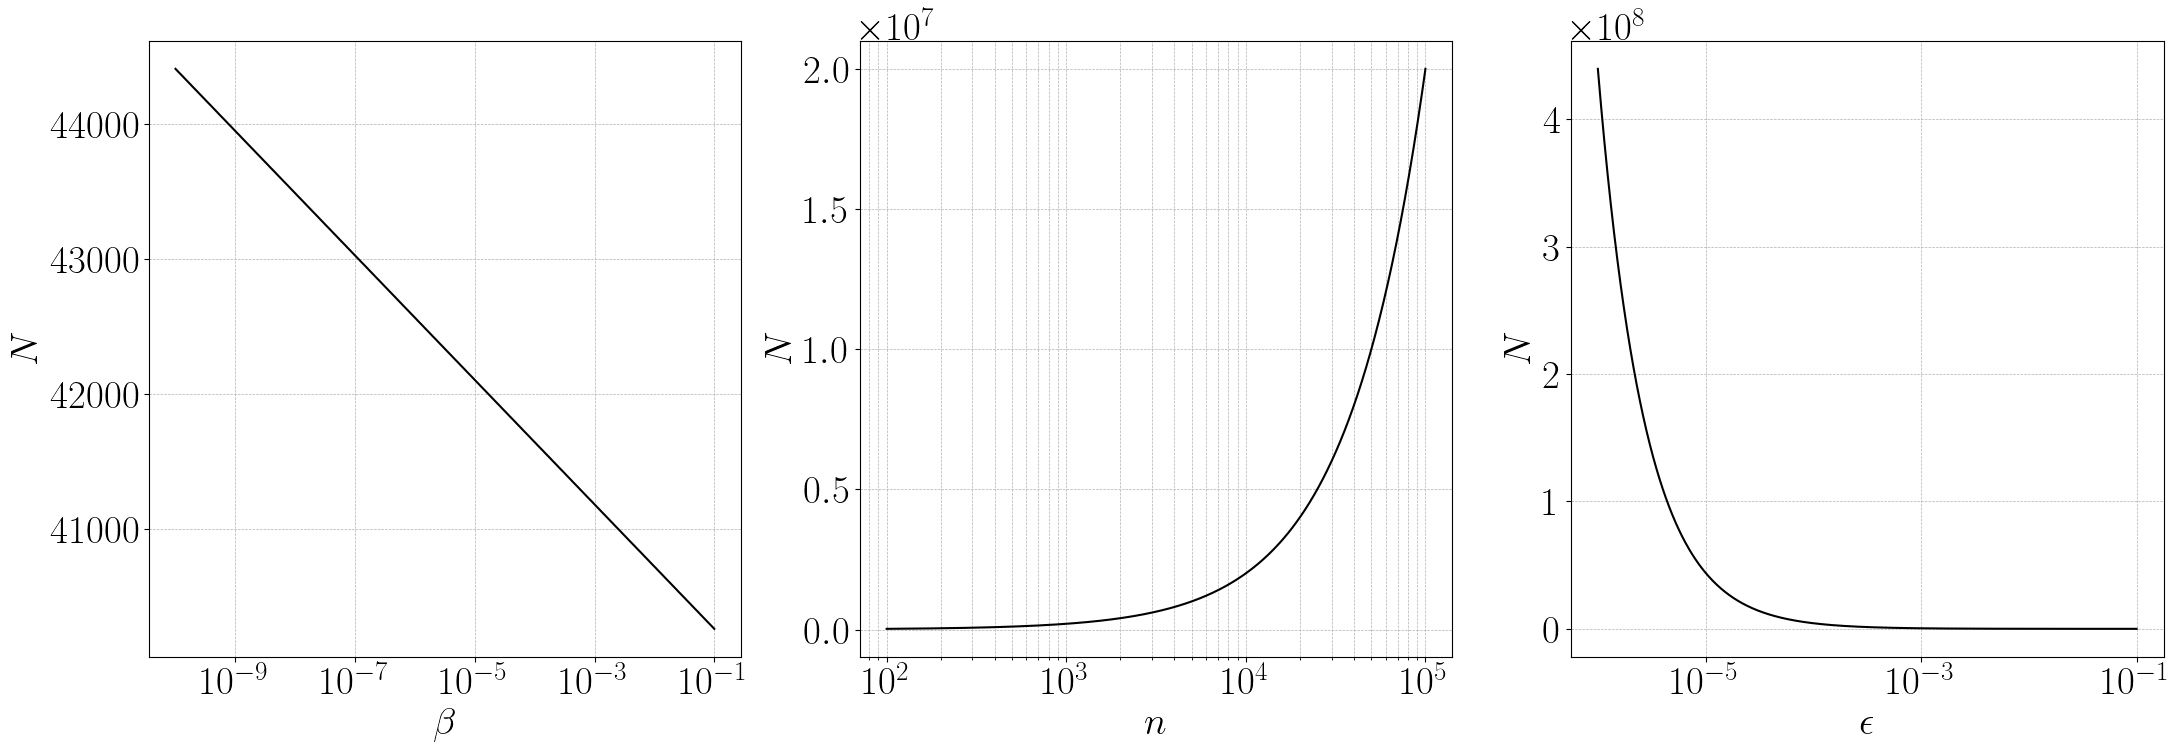

In [9]:
# Plot number of samples required in scenario approach
epsilon_values = np.logspace(-6, -1, 500)
beta_values = np.logspace(-10, -1, 500)
n_values = np.logspace(2, 5, 500)

# Compute the function for each epsilon
N_dict = {'\\epsilon': (epsilon_values, np.ceil(2 / epsilon_values * (np.log(1 / beta) + n - 1))),
          '\\beta': (beta_values, np.ceil(2 / epsilon * (np.log(1 / beta_values) + n - 1))),
          'n': (n_values, np.ceil(2 / epsilon * (np.log(1 / beta) + n_values - 1)))}

fig, axes = plt.subplots(1, 3, figsize=(26, 8))
params = ['\\beta', 'n', '\\epsilon']

for i, param in enumerate(params):
    x_values, y_values = N_dict[param]
    axes[i].plot(x_values, y_values, color='black')
    axes[i].set_xscale('log')
    axes[i].set_xlabel(r'$%s$' % param)
    axes[i].set_ylabel(r'$N$')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout
plt.savefig("scenario_samples.pdf", bbox_inches="tight")
